# Installation

In [1]:
!pip install torchsummary

# Imports

In [2]:
# Standard library imports
import os
import time
import pickle
from collections import defaultdict

# Data handling and visualization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# PyTorch imports for neural network architecture and data handling
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
from torch.utils.data import DataLoader
from torchsummary import summary

# torchvision for pre-trained models, datasets, and image transformations
from torchvision import datasets, transforms

# Data augmentation
import kornia.augmentation as K
from kornia.augmentation import AugmentationSequential

# Scikit-learn for evaluation metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Optuna for hyperparameter optimization
import optuna

# Enable inline plotting for Jupyter notebooks
%matplotlib inline

# Plotly for interactive visualizations
import plotly.io as pio

# Set Plotly renderer to Jupyter notebook
pio.renderers.default = 'notebook_connected'

# Dataset

## Helper functions

In [3]:
def get_classes_names(data_path):
    classes_names = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]
    return classes_names

# Function to apply the transformations on the datasets 
def load_and_transform_datasets(data_path):
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(98),
            transforms.ToTensor(),
            transforms.Normalize([0.482, 0.468, 0.419], [0.209, 0.206, 0.221])
        ]),

        'val': transforms.Compose([
            transforms.Resize(100),
            transforms.CenterCrop(98),
            transforms.ToTensor(),
            transforms.Normalize([0.482, 0.468, 0.419], [0.209, 0.206, 0.221])
        ]),

        'test': transforms.Compose([
            transforms.Resize(100),
            transforms.CenterCrop(98),
            transforms.ToTensor(),
            transforms.Normalize([0.482, 0.468, 0.419], [0.209, 0.206, 0.221])
        ])
    }
    
    image_datasets = {
        'train': datasets.ImageFolder(root=os.path.join(data_path, 'train'), transform=data_transforms['train']),
        'val': datasets.ImageFolder(root=os.path.join(data_path, 'val'), transform=data_transforms['val']),
        'test': datasets.ImageFolder(root=os.path.join(data_path, 'test'), transform=data_transforms['test'])
    }
    
    return image_datasets

def show_images(dataloader, num_images=6):
    # Prepare the figure
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    axes = axes.flatten()
    
    classes_names = dataloader.dataset.classes
    data_mean = np.array([0.482, 0.468, 0.419]) 
    data_std = np.array([0.209, 0.206, 0.221])

    dataloader_iter = iter(dataloader)
    
    # Fetch a batch of images and labels
    images, labels = next(dataloader_iter)
    
    for i in range(num_images):
        # Convert tensor image to numpy array
        image = images[i].numpy().transpose(1, 2, 0)  # Change shape from CxHxW to HxWxC
        
        # Denormalize the image
        image = image * data_std + data_mean
        image = np.clip(image, 0, 1)
        
        label = labels[i].item()
        
        axes[i].imshow(image)
        axes[i].set_title(classes_names[label])
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()
    
# Function to summarizes the dataset structure and class distribution without loading actual data.
def summarize_datasets(data_path):
    # Initialize class counts for each dataset
    class_counts = {
        'train': defaultdict(int),
        'val': defaultdict(int),
        'test': defaultdict(int)
    }
    
    # Define directory names
    split_dirs = ['train', 'val', 'test']
    
    # Get the list of class names (assuming each subfolder in train, val, and test folders is a class)
    all_classes = set()
    for split in split_dirs:
        split_dir = os.path.join(data_path, split)
        if os.path.isdir(split_dir):
            classes_names = os.listdir(split_dir)
            all_classes.update(classes_names)
            for class_name in classes_names:
                class_counts[split][class_name] = len(os.listdir(os.path.join(split_dir, class_name)))

    # Prepare the table data for visualization
    table_data = []

    # Create the header row for the table
    header_row = ["Class"] + ['Train', 'Validation', 'Test', 'Total']
    table_data.append(header_row)

    # Add data rows for each class
    for class_name in sorted(all_classes):
        train_count = class_counts['train'].get(class_name, 0)
        val_count = class_counts['val'].get(class_name, 0)
        test_count = class_counts['test'].get(class_name, 0)
        total_count = train_count + val_count + test_count
        row = [class_name, train_count, val_count, test_count, total_count]
        table_data.append(row)

    # Add the last row with totals
    total_train = sum(class_counts['train'].values())
    total_val = sum(class_counts['val'].values())
    total_test = sum(class_counts['test'].values())
    overall_total = total_train + total_val + total_test
    total_row = ["Total", total_train, total_val, total_test, overall_total]
    table_data.append(total_row)

    # Create a DataFrame for better visualization
    df = pd.DataFrame(table_data[1:], columns=table_data[0])

    # Apply alignment styles and borders for the DataFrame
    styles = [
        {'selector': 'th', 'props': [('text-align', 'center'), ('border', '1px solid black')]}, 
        {'selector': 'td', 'props': [('text-align', 'center'), ('border', '1px solid black')]}, 
    ]

    styled_df = df.style.set_table_styles(styles)

    return styled_df

In [4]:
# Define a list of data augmentations using Kornia
aug_list = AugmentationSequential(
    K.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05, p=0.3),
    K.RandomAffine(degrees=15, translate=(0.05, 0.05), scale=(0.9, 1.1), p=0.5),
    K.RandomHorizontalFlip(p=0.5),
    same_on_batch=False,
)

## Visualization

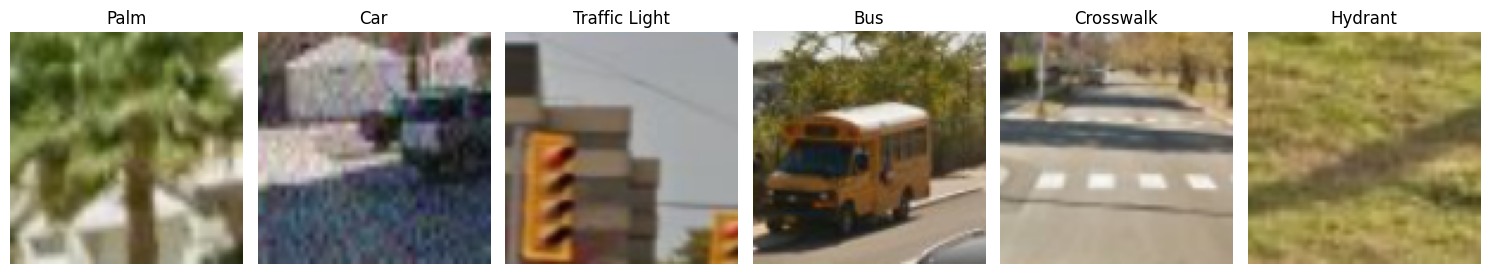

In [5]:
data_path = '../dataset'

image_datasets = load_and_transform_datasets(data_path)

train_dataloader = DataLoader(image_datasets['train'], batch_size=128, num_workers=2, shuffle=True)
show_images(train_dataloader, num_images=6)

In [6]:
summarized_table = summarize_datasets(data_path)
display(summarized_table)

,Class,Train,Validation,Test,Total
0,Bicycle,1705,365,366,2436
1,Bridge,1267,271,273,1811
2,Bus,5862,1256,1257,8375
3,Car,6776,1452,1453,9681
4,Chimney,272,58,59,389
5,Crosswalk,2307,494,495,3296
6,Hydrant,4872,1044,1045,6961
7,Motorcycle,193,41,43,277
8,Palm,1791,383,385,2559
9,Stair,450,96,98,644


# Device

In [7]:
# Device configuration:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


# Initialize Our Custom DINOv2 Classifier

In [8]:
class dinoClassifierModel(nn.Module):
    def __init__(self, hidden_dim, out_dim, activation):
        super(dinoClassifierModel, self).__init__()

        # Load the pre-trained DINOv2 model from the torch hub
        self.transformer = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')

        # Size of the embedding output from the DINOv2 model
        self.embedding_size = 384

        # Define the activation function based on the string provided
        if activation == "ReLU":
            self.activation_layer = nn.ReLU()
        elif activation == "PReLU":
            self.activation_layer = nn.PReLU()
        elif activation == "LeakyReLU":
            self.activation_layer = nn.LeakyReLU()
        else:
            raise ValueError(f"Unsupported activation: {activation}")

        # Define a sequential classifier layer with linear layers and the chosen activation
        self.classifier = nn.Sequential(
            nn.Linear(self.embedding_size, hidden_dim),
            self.activation_layer,
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x):
        # Extract features using the pre-trained DINOv2 model
        x = self.transformer(x)
        
        # Normalize the output features
        x = self.transformer.norm(x)
        
        # Pass the features through the classifier
        x = self.classifier(x)
        return x

In [9]:
classes_names = get_classes_names(data_path+'/train')
num_classes = len(classes_names)

# Dimensions, Parameters and Size
dummy_model = dinoClassifierModel(hidden_dim=256, out_dim=num_classes, activation='ReLU')
dummy_model = dummy_model.to(device)

# Print the model
print(dummy_model)

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning:

xFormers is not available (SwiGLU)

/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning:

xFormers is not available (Attention)

/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning:

xFormers is not available (Block)

Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth
100%|██████████| 84.2M/84.2M [00:01<00:00, 85.0MB/s]


dinoClassifierModel(
  (transformer): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-11): 12 x NestedTensorBlock(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=False)

In [10]:
# Print a summary of the model
summary(dummy_model, (3, 98, 98))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 384, 7, 7]         226,176
          Identity-2              [-1, 49, 384]               0
        PatchEmbed-3              [-1, 49, 384]               0
         LayerNorm-4              [-1, 50, 384]             768
            Linear-5             [-1, 50, 1152]         443,520
           Dropout-6            [-1, 6, 50, 50]               0
            Linear-7              [-1, 50, 384]         147,840
           Dropout-8              [-1, 50, 384]               0
   MemEffAttention-9              [-1, 50, 384]               0
       LayerScale-10              [-1, 50, 384]               0
        LayerNorm-11              [-1, 50, 384]             768
           Linear-12             [-1, 50, 1536]         591,360
             GELU-13             [-1, 50, 1536]               0
          Dropout-14             [-1, 5

# Helper Functions

In [11]:
# Objective function for Optuna with activation function optimization
def objective(trial):
    # Hyperparameters to study
    hidden_dim = trial.suggest_int("hidden_dim", 64, 1024)
    activation = trial.suggest_categorical("activation", ["ReLU", "PReLU", "LeakyReLU"])
    
    # Create model with the trial parameters
    model = dinoClassifierModel(hidden_dim=hidden_dim, out_dim=num_classes, activation=activation)
    model = model.to(device)

    # Additional hyperparameters
    batch_size = trial.suggest_int("batch_size", 64, 512)
    num_epochs = trial.suggest_int("num_epochs", 10, 30)
    lr = trial.suggest_float("lr", 1e-9, 1e-4, log=True)

    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop"])
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr)

    # Scheduler selection
    scheduler_type = trial.suggest_categorical("scheduler", ["StepLR", "CosineAnnealingLR"])
    if scheduler_type == "StepLR":
        scheduler = StepLR(optimizer, step_size=trial.suggest_int("step_size", 2, 10), gamma=trial.suggest_float("gamma", 0.1, 0.5))
    else:
        scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=lr / 100)

    # Get the Imagenette dataset
    train_loader = DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=2)
    valid_loader = DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=True, num_workers=2)

    # Define criterion
    criterion = nn.CrossEntropyLoss()

    n_train_examples = batch_size * 30
    n_valid_examples = batch_size * 10

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for batch_idx, (images, labels) in enumerate(train_loader):
            if batch_idx * batch_size >= n_train_examples:
                break
                
            images, labels = images.to(device), labels.to(device)
            images = aug_list(images)
                
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
        scheduler.step()

        # Validation loop
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(valid_loader):
                if batch_idx * batch_size >= n_valid_examples:
                    break
                    
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted.view(-1) == labels).sum().item()

        accuracy = correct / min(len(valid_loader.dataset), n_valid_examples)

        trial.report(accuracy, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

# Function for training the model
def train_model(model, dataloaders, criterion, optimizer, num_epochs, scheduler=None, model_name_to_save='tmp'):
    model.to(device)
    model.train()
    
    epoch_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        batch_losses = []
        total_correct_train = 0
        total_samples_train = 0
        
        epoch_start_time = time.time()

        # Training phase
        model.train()
        for data in dataloaders["train"]:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            images = aug_list(images) #augmentation
            
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            
            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            
            # Optimize
            optimizer.step()
            
            batch_losses.append(loss.item())
            
            # Calculate and accumulate accuracy
            _, predicted_classes = torch.max(outputs.data, 1)
            total_correct_train += (predicted_classes == labels).sum().item()
            total_samples_train += labels.size(0)
        
        # Step the scheduler if provided
        if scheduler:
            scheduler.step()

        # Calculate average loss and training accuracy for the epoch
        epoch_loss = np.mean(batch_losses)
        epoch_losses.append(epoch_loss)

        train_accuracy = total_correct_train / total_samples_train
        train_accuracies.append(train_accuracy)
        
        epoch_time = time.time() - epoch_start_time

        # Validation phase
        model.eval()
        total_correct_val = 0
        total_samples_val = 0
        with torch.no_grad():
            for data in dataloaders["val"]:
                images, labels = data
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                _, predicted_classes = torch.max(outputs.data, 1)
                total_correct_val += (predicted_classes == labels).sum().item()
                total_samples_val += labels.size(0)
        
        val_accuracy = total_correct_val / total_samples_val
        val_accuracies.append(val_accuracy)

        print(f"Epoch: {epoch+1}/{num_epochs} | Loss: {epoch_loss:.4f} | Training Accuracy: {100*train_accuracy:.2f}% | Validation Accuracy: {100*val_accuracy:.2f}% | Epoch Time: {epoch_time:.2f} secs") 

        # Save model at every 10th epoch if model_name_to_save is provided
        if model_name_to_save and (epoch+1) % 10 == 0:
            print('==> Saving model ...')
            state = {
                'net': model.state_dict(),
                'epoch': epoch,
            }
            if not os.path.isdir('checkpoints'):
                os.mkdir('checkpoints')
            torch.save(state, f'./checkpoints/{model_name_to_save}.pth')

    print('==> Finished Training ...')

    # Save the model after the final epoch
    state = {
        'net': model.state_dict(),
        'epoch': epoch,
    }
    if not os.path.isdir('checkpoints'):
        os.mkdir('checkpoints')
    torch.save(state, f'./checkpoints/{model_name_to_save}.pth')
    
    return epoch_losses, train_accuracies, val_accuracies


# Function for testing the model
def test_model(model, dataloaders):
    model.eval()
    
    total_correct = 0
    total_images = 0
    test_predicted = []
    test_labels = []

    with torch.no_grad():
        for data in dataloaders['test']:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            
            test_labels += (labels.cpu().numpy().tolist())
            test_predicted += (predicted.cpu().numpy().tolist())

    model_accuracy = total_correct / total_images
    print(f"Model accuarcy is: {100*model_accuracy:.3f}%")
    
    return test_labels, test_predicted

# Function to show the confusion matrix
def show_confusion_matrix(df_cm, title='Confusion Matrix'):
    plt.figure(figsize=(10, 7))
    sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

# Hyperparameters tuning with Optuna

In [12]:
# Run the Optuna experiment
sampler = optuna.samplers.TPESampler()
study = optuna.create_study(study_name="dino_study", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=200, timeout=10000)

# Results summary
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

# Save the study
with open("optuna_study.pkl", "wb") as f:
    pickle.dump(study, f)
    
# Prints the study results
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial
print(f"  Accuracy: {trial.value:.4f}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-08-24 19:03:52,428] A new study created in memory with name: dino_study
Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
[I 2024-08-24 19:23:51,652] Trial 0 finished with value: 0.0970703125 and parameters: {'hidden_dim': 526, 'activation': 'ReLU', 'batch_size': 512, 'num_epochs': 28, 'lr': 1.7999443138225797e-09, 'optimizer': 'Adam', 'scheduler': 'StepLR', 'step_size': 10, 'gamma': 0.1324513085625176}. Best is trial 0 with value: 0.0970703125.
Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
[I 2024-08-24 19:38:23,422] Trial 1 finished with value: 0.7663841807909605 and parameters: {'hidden_dim': 691, 'activation': 'ReLU', 'batch_size': 354, 'num_epochs': 29, 'lr': 2.410238298446919e-07, 'optimizer': 'Adam', 'scheduler': 'CosineAnnealingLR'}. Best is trial 1 with value: 0.7663841807909605.
Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
[I 2024-08-24 19:53:59,090] Trial 2 finished with value: 0.8728506787

Study statistics: 
  Number of finished trials:  20
  Number of pruned trials:  6
  Number of complete trials:  14
Best trial:
  Accuracy: 0.9562
  Params: 
    hidden_dim: 499
    activation: LeakyReLU
    batch_size: 450
    num_epochs: 23
    lr: 2.3773444678229302e-05
    optimizer: Adam
    scheduler: StepLR
    step_size: 8
    gamma: 0.19340056953377444


In [13]:
optuna.visualization.plot_param_importances(study)

In [14]:
optuna.visualization.plot_parallel_coordinate(study)

# Create a model with the best parameters

In [15]:
import joblib
# Now let's load the study from the pickle file
study = joblib.load("optuna_study.pkl")
trial = study.best_trial

# Extract parameters from the best trial
optuna_hidden_dim = trial.params["hidden_dim"]
optuna_activation = trial.params["activation"]
optuna_batch_size = trial.params["batch_size"]
optuna_num_epochs = trial.params["num_epochs"]
optuna_lr = trial.params["lr"]
optuna_optimizer_name = trial.params["optimizer"]
optuna_scheduler = trial.params["scheduler"]

# Create model with the trial parameters
best_model = dinoClassifierModel(hidden_dim=optuna_hidden_dim, out_dim=num_classes, activation=optuna_activation)
best_model = best_model.to(device)

# Define optimizer using getattr to dynamically get the optimizer class
optimizer_class = getattr(optim, optuna_optimizer_name)
if optimizer_class is None:
    raise ValueError(f"Unsupported optimizer: {optuna_optimizer_name}")

optimizer = optimizer_class(best_model.parameters(), lr=optuna_lr)

# Define criterion
criterion = nn.CrossEntropyLoss()

# Define scheduler based on the chosen option
if optuna_scheduler == 'StepLR':
    optuna_step_size = trial.params["step_size"]
    optuna_gamma = trial.params["gamma"]
    scheduler = StepLR(optimizer, step_size=optuna_step_size, gamma=optuna_gamma)
else:
    scheduler = CosineAnnealingLR(optimizer, T_max=optuna_num_epochs, eta_min=optuna_lr / 100)

# Prepare the dataloaders with the best batch size
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=optuna_batch_size, num_workers=2, shuffle=True),
    'val': DataLoader(image_datasets['val'], batch_size=optuna_batch_size, num_workers=2, shuffle=False),
    'test': DataLoader(image_datasets['test'], batch_size=optuna_batch_size, num_workers=2, shuffle=False)
}

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


#  Train

In [16]:
# Train the model
epoch_losses, train_accuracies, val_accuracies = train_model(best_model, dataloaders, criterion, optimizer, num_epochs=optuna_num_epochs, scheduler=scheduler, model_name_to_save='dino_classifier')

Epoch: 1/23 | Loss: 0.8213 | Training Accuracy: 74.03% | Validation Accuracy: 93.43% | Epoch Time: 65.26 secs
Epoch: 2/23 | Loss: 0.4888 | Training Accuracy: 84.20% | Validation Accuracy: 94.46% | Epoch Time: 65.09 secs
Epoch: 3/23 | Loss: 0.4383 | Training Accuracy: 85.82% | Validation Accuracy: 94.40% | Epoch Time: 65.10 secs
Epoch: 4/23 | Loss: 0.4251 | Training Accuracy: 85.98% | Validation Accuracy: 95.10% | Epoch Time: 65.28 secs
Epoch: 5/23 | Loss: 0.4073 | Training Accuracy: 86.69% | Validation Accuracy: 94.73% | Epoch Time: 65.08 secs
Epoch: 6/23 | Loss: 0.3949 | Training Accuracy: 87.01% | Validation Accuracy: 94.96% | Epoch Time: 65.00 secs
Epoch: 7/23 | Loss: 0.3864 | Training Accuracy: 87.32% | Validation Accuracy: 94.91% | Epoch Time: 65.05 secs
Epoch: 8/23 | Loss: 0.3774 | Training Accuracy: 87.50% | Validation Accuracy: 95.33% | Epoch Time: 65.10 secs
Epoch: 9/23 | Loss: 0.3375 | Training Accuracy: 88.60% | Validation Accuracy: 95.83% | Epoch Time: 65.06 secs
Epoch: 10/

In [17]:
import csv 

# Export the accuracy histories to a CSV file
with open('dino_accuracy_history.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Train Accuracy', 'Validation Accuracy'])

    for epoch in range(len(train_accuracies)):
        writer.writerow([epoch + 1, train_accuracies[epoch], val_accuracies[epoch]])

print("Accuracy histories exported to 'dino_accuracy_history.csv'")

Accuracy histories exported to 'dino_accuracy_history.csv'


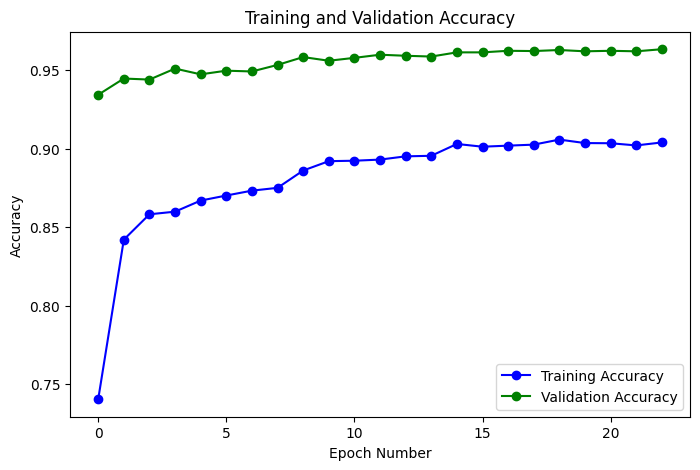

In [18]:
# Plotting train and validation accuracy vs epoch
plt.figure(figsize=(8, 5))

plt.plot(train_accuracies, label='Training Accuracy', color='blue', linestyle='-', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', color='green', linestyle='-', marker='o')

plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch Number")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

# Test

In [19]:
test_labels, test_predicted = test_model(best_model, dataloaders)

Model accuarcy is: 95.926%


In [20]:
# Display the classification report
print(classification_report(test_labels, test_predicted, target_names=classes_names))

               precision    recall  f1-score   support

   Motorcycle       0.97      0.97      0.97       366
      Hydrant       0.89      0.93      0.91       273
          Bus       0.97      0.99      0.98      1257
          Car       0.94      0.92      0.93      1453
    Crosswalk       0.98      1.00      0.99        59
        Stair       0.94      0.96      0.95       495
Traffic Light       1.00      1.00      1.00      1045
       Bridge       0.92      0.77      0.84        43
      Bicycle       0.97      0.94      0.96       385
         Palm       0.97      0.96      0.96        98
      Chimney       0.92      0.94      0.93       540

     accuracy                           0.96      6014
    macro avg       0.95      0.94      0.95      6014
 weighted avg       0.96      0.96      0.96      6014



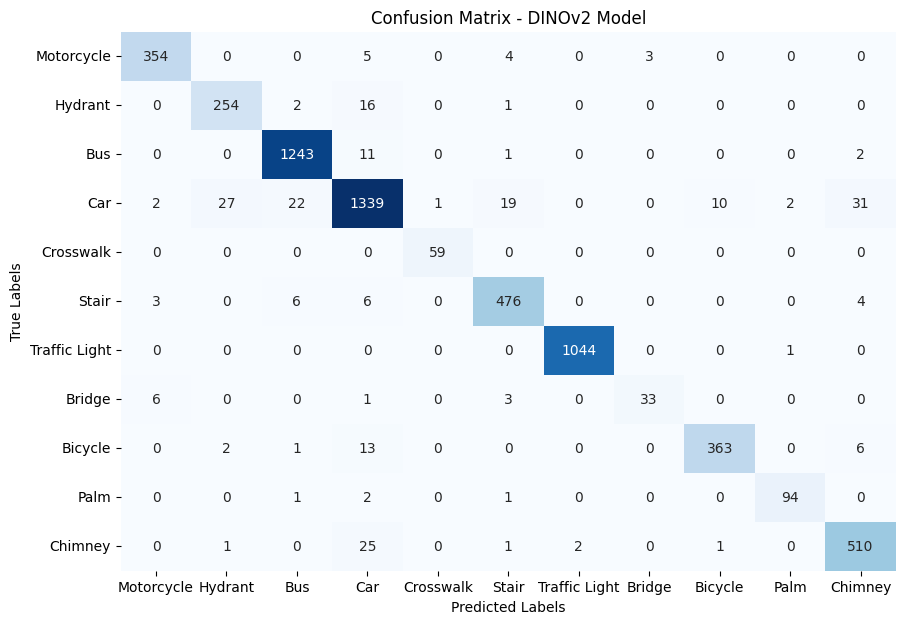

In [21]:
# Display the confusion matrix
cm = confusion_matrix(test_labels, test_predicted)
df_cm = pd.DataFrame(cm, index=classes_names, columns=classes_names)
show_confusion_matrix(df_cm, title='Confusion Matrix - DINOv2 Model')